In [ ]:
#Third Model. 
#Data Augmentation with ImageDataGenerator
#Hyperparameters tunning with Hyperas

In [3]:
from __future__ import print_function
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import uniform
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import h5py

from keras.optimizers import Adam
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

%matplotlib inline
import matplotlib.pyplot as plt

/Users/claugreco/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
def data():
    nb_classes = 1
    
    df = pd.read_csv('data.csv')
    df = df.drop('Unnamed: 0', axis=1)
    y= df['label']
    X= df.drop('label', axis=1)

    # Train/Test Split
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=142)
    
    print('X_train shape:', X_train.shape)
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')
    
    scaler = MinMaxScaler(feature_range = (0,1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    
    X_train = X_train.reshape(X_train.shape[0], 256, 150, 1)
    X_test = X_test.reshape(X_test.shape[0], 256, 150, 1)

    # this will do preprocessing and realtime data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(X_train)

    return datagen, X_train, Y_train, X_test, Y_test

In [5]:
def model(datagen, X_train, Y_train, X_test, Y_test):

    nb_epoch = 15

    # input image dimensions
    img_rows, img_cols = 256, 150
    img_channels = 1

    model = Sequential()

    model.add(Conv2D({{choice([90])}}, (5,5), padding='same',
                            input_shape=X_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (4,4), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout({{uniform(0, 1)}}))

    model.add(Flatten())
    model.add(Dense(1000))
    model.add(Activation('relu'))
    model.add(Dropout({{uniform(0, 1)}}))
    
    model.add(Dense(nb_classes))
    model.add(Activation('relu'))

    adam = Adam()
    model.compile(loss='mean_absolute_error',
                  optimizer=adam, 
                  metrics=['mean_squared_error'])

    # fit the model on the batches generated by datagen.flow()
    model.fit_generator(datagen.flow(X_train, Y_train,
                        batch_size={{choice([64, 128])}}),
                        nb_epoch=nb_epoch,
                        validation_data=(X_test, Y_test))

    score, acc = model.evaluate(X_test, Y_test, verbose=0)

    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [6]:
%%timeit -n1 -r1

datagen, X_train, Y_train, X_test, Y_test = data()

best_run, best_model, space = optim.minimize(model=model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=2,
                                          trials=Trials(),
                                          eval_space=True,  
                                          return_space=True,
                                          notebook_name='CNN_model3')


X_train shape: (394, 38400)
394 train samples
99 test samples
>>> Imports:
#coding=utf-8

from __future__ import print_function

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import uniform
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers.core import Dense, Dropout, Activation, Flatten
except:
    pass

try:
    from keras.layers.convolutional import MaxPooling2D
except:
    pass

try:
    from keras.layers import Conv2D
except:
    pass

try:
    from keras.preprocessing.image import ImageDataGenerator
except:
    pass

try:
    from keras.utils import np_utils
except:
    pass

try:
    import h5py
except:
    pass

try:
    from keras.optimizers import Adam
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from

In [7]:
best_model.save("best_model3.h5")

In [8]:
print("Evalutation of best performing model:")
print(best_model.evaluate(X_test, Y_test))

Evalutation of best performing model:
99/99 [==============================] - 6s 57ms/step
[11.493547295079086, 194.93753020931976]


In [9]:
print("Parameters of best run", best_run)

Parameters of best run {'Conv2D': 45, 'Dense': 1024, 'Dropout': 0.692539034315719, 'Dropout_1': 0.21280043312755825, 'batch_size': 32}


In [ ]:
print(best_model.summary())

In [10]:
preds_test = best_model.predict(X_test)
preds_train = best_model.predict(X_train)

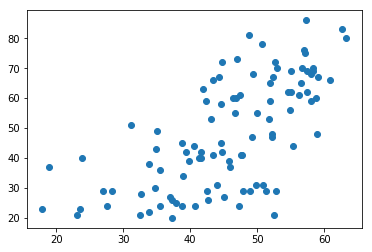

In [11]:
plt.scatter(preds, y_test, color='gray');
plt.xlabel('CNN Predicted Age (years)')
plt.plot([min(y_test),max(y_test)],[min(y_test),max(y_test)])
plt.ylabel('Age (years)')
plt.show()

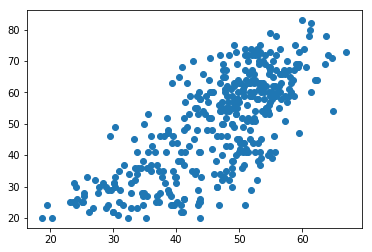

In [12]:
plt.scatter(preds_train, y_train, color='gray');
plt.xlabel('CNN Predicted Age (years)')
plt.ylabel('Age (years)')
plt.plot([min(y_train),max(y_train)],[min(y_train),max(y_train)])
plt.show()

In [13]:
r_score_test = r2_score(Y_test, preds_test)
print (r_score_test)

0.4110043828722404


In [14]:
r_score_train = r2_score(Y_train, preds_train)
print (r_score_train)

0.47932521103166204


In [ ]:
import gc; gc.collect()